In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [279]:
raw_data = pd.read_csv('../datasets/bars_v1.csv', delimiter = ',')
raw_data.head()

,t,o,h,l,c,v,n,vw,symbol
0,2015-12-01 09:00:00+00:00,118.88,118.94,118.60,118.65,5825,15,118.696799,AAPL
1,2015-12-01 09:00:00+00:00,84.05,84.20,83.50,83.90,15743,49,83.890588,BABA
2,2015-12-01 09:00:00+00:00,668.00,668.49,667.89,667.89,882,10,668.056961,AMZN
3,2015-12-01 09:00:00+00:00,746.00,746.00,746.00,746.00,138,1,746.000000,GOOG
4,2015-12-01 09:00:00+00:00,104.42,104.42,104.42,104.42,200,1,104.420000,META


In [280]:
# Assuming your DataFrame is called df
# First, reset the 'symbol' index level, so that resample() only operates on the 't' level
raw_data['t'] = pd.to_datetime(raw_data['t'])
df = raw_data.set_index(['t', 'symbol']).sort_index()

# Define custom aggregation functions for each column
agg_funcs = {
    'o': 'first',   # Open: first value of the day
    'h': 'max',     # High: maximum value of the day
    'l': 'min',     # Low: minimum value of the day
    'c': 'last',    # Close: last value of the day
    'v': 'sum',     # Volume: sum of values for the day
    'n': 'sum',     # Number of trades: sum of values for the day
    'vw': 'mean',   # Volume-weighted price: mean value of the day
}

# Group the DataFrame by symbol and apply resampling and aggregation functions to each group
daily_groups = []
for symbol, group in df.groupby('symbol'):
    group = group.droplevel('symbol')  # Drop 'symbol' from the index
    daily_group = group.resample('1D', level='t').agg(agg_funcs).dropna()
    daily_group['symbol'] = symbol
    daily_groups.append(daily_group)

# Combine the daily groups back into a single DataFrame and set the multi-index
daily_df = pd.concat(daily_groups)
daily_df = daily_df.reset_index().set_index(['t', 'symbol']).sort_index()


In [281]:
daily_df.head(20)

o        h       l         c         v  \
t                         symbol                                                
2015-12-01 00:00:00+00:00 AAPL    118.88  119.000  116.86  117.2300  34751854   
                          AMZN    668.00  681.000  666.99  679.3000   4739843   
                          BABA     84.05   84.390   83.50   83.9999  26101326   
                          BAC      17.47   17.860   17.46   17.8500  74313148   
                          CVX      91.45   92.650   90.97   92.5000   6967643   
                          GOOG    746.00  768.950  745.50  767.1000   2125994   
                          JPM      66.82   67.830   66.82   67.6100  12281767   
                          KO       42.72   43.100   42.71   42.8900  11129337   
                          META    104.42  107.180  104.41  107.1300  22702757   
                          MSFT     54.49   55.300   54.30   55.2500  39828152   
                          NVDA     31.90   32.780   31.88   32.6800  10129613   
                          PFE      33.00   33.730   32.62   33.6200  49291832   
                          TSLA    231.06  238.000  229.80  237.0300   3729405   
                          XOM      81.70   82.130   81.27   81.8900  13889950   
2015-12-02 00:00:00+00:00 AAPL    117.28  118.110  116.08  116.4000  33226679   
                          AMZN    679.00  684.820  674.25  676.6000   4244272   
                          BABA     84.10   87.000   83.95   85.0600  36594516   
                          BAC      17.85   17.960   17.55   17.6400  76761241   
                          CVX      92.48   93.200   90.03   90.5100  11743033   
                          GOOG    766.50  775.955  758.96  763.2700   2218482   

                                       n          vw  
t                         symbol                      
2015-12-01 00:00:00+00:00 AAPL    186962  118.028408  
                          AMZN     58524  674.331155  
                          BABA    153357   83.942627  
                          BAC     125938   17.650042  
                          CVX      55735   92.137977  
                          GOOG     34959  759.140407  
                          JPM      77143   67.336163  
                          KO       59223   42.886605  
                          META    130350  105.806101  
                          MSFT    194727   54.829764  
                          NVDA     57475   32.436754  
                          PFE     169215   33.342679  
                          TSLA     34749  235.174913  
                          XOM      84626   81.664603  
2015-12-02 00:00:00+00:00 AAPL    180578  117.159981  
                          AMZN     53177  679.189790  
                          BABA    183016   84.932949  
                          BAC     122551   17.743299  
                          CVX      79477   91.369436  
                          GOOG     34843  766.587324

In [282]:
print(daily_df.shape)
daily_df.isna().sum() / len(daily_df)

(27595, 7)


o     0.0
h     0.0
l     0.0
c     0.0
v     0.0
n     0.0
vw    0.0
dtype: float64

In [283]:
def process_stock_data(df):
    # df['t'] = pd.to_datetime(df['t'])
    # df = df.set_index('t')
    # df = df.drop(columns=['symbol'])
    return df

In [284]:
stocks_data = {}
for symbol, stock_df in daily_df.groupby('symbol'):
    stocks_data[symbol] = process_stock_data(stock_df)

In [285]:
print(stocks_data['AAPL'].shape)
stocks_data['AAPL'].head()

(1990, 7)


,,o,h,l,c,v,n,vw
t,symbol,,,,,,,
2015-12-01 00:00:00+00:00,AAPL,118.88,119.00,116.86,117.23,34751854,186962,118.028408
2015-12-02 00:00:00+00:00,AAPL,117.28,118.11,116.08,116.40,33226679,180578,117.159981
2015-12-03 00:00:00+00:00,AAPL,116.42,117.30,114.22,115.39,41551689,245283,115.950119
2015-12-04 00:00:00+00:00,AAPL,115.38,119.25,115.01,119.05,56682039,307695,117.409714
2015-12-05 00:00:00+00:00,AAPL,119.05,119.07,119.04,119.05,5236,23,119.053669


In [286]:
def rsi(x):
    delta = x['c'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(span=14).mean()
    avg_loss = loss.ewm(span=14).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [287]:
transformations_v0 = {
    'range': (lambda x: x['h'] - x['l']),
    'avg_price': (lambda x: (x['o'] + x['h'] + x['l'] + x['c']) / 4),
    'price_change': lambda x: x['c'] - x['o'],
    'pct_price_change': lambda x: (x['c'] - x['o']) / x['o'] * 100,
    'log_return': lambda x: np.log(x['vw'] / x['vw'].shift(1)),
    'smaS': lambda x: x['c'].rolling(window=11).mean(),
    'smaM': lambda x: x['c'].rolling(window=33).mean(),
    'smaL': lambda x: x['c'].rolling(window=77).mean(),
    'emaS': lambda x: x['c'].ewm(span=11).mean(),
    'emaM': lambda x: x['c'].ewm(span=33).mean(),
    'emaL': lambda x: x['c'].ewm(span=77).mean(),
    'obv': lambda x: (np.sign(x['c'].diff()) * x['v']).fillna(0).cumsum(),
    'vwap': lambda x: (x['vw'] / x['v']).cumsum(),
    'log_v': lambda x: np.log(x['v']),
    'log_n': lambda x: np.log(x['n']),
    'log_vw': lambda x: np.log(x['vw']),
    'log_avg_price': lambda x: np.log(x['avg_price']),
    'scaled_pct_price_change': lambda x: (x['pct_price_change'] - x['pct_price_change'].mean()) / x['pct_price_change'].std(),
    'scaled_log_return': lambda x: (x['log_return'] - x['log_return'].mean()) / x['log_return'].std(),
    'detrended_c': lambda x: x['c'] - x['ema50'],
    'sma_vwap': lambda x: x['vwap'].rolling(window=14).mean(),
    'detrended_vwap': lambda x: x['vwap'] - x['sma_vwap'],
    'standardized_obv': lambda x: (x['obv'] - x['obv'].mean()) / x['obv'].std(),
    'rsi': lambda x: rsi(x)
}

In [288]:

# Solo se usan los atributos marcados con una 'x'

# -> Atributos originales
# ( ) o  -> x['o']
# ( ) h  -> x['h']
# ( ) c  -> x['c']
# ( ) l  -> x['l']
# ( ) v  -> x['v']
# ( ) vw -> x['vw']
# ( ) n  -> x['n']
# ---
# -> Atributos para calcular evaluaciones generales del cambio de precio
# ( ) diff -> x['vw'] / x['vw'].shift(1)
# ( ) s    -> x['diff'].ewm(span=77).std()
# (x) emaS -> x['diff'].ewm(span=11).mean()    -> Tendencia al corto plazo (1 dia)
# (x) emaM -> x['diff'].ewm(span=33).mean()    -> Tendencia al medio plazo (3 dias)
# (x) emaL -> x['diff'].ewm(span=77).mean()    -> Tendencia al largo plazo (1 semana)
# (x) std  -> np.log(x['s'])                   -> Log de la std móvil a largo plazo
# (x) pc   -> (x['diff'] - x['emaL']) / x['s'] -> Variación del precio mobil normalizado
# ---
# (x) mvS -> np.log(x['v']).ewm(span=11).mean() -> Log del Volumen medio al corto plazo
# (x) mvL -> np.log(x['v']).ewm(span=77).mean() -> Log del Volumen medio al largo plazo
# (x) mnS -> np.log(x['n']).ewm(span=11).mean() -> Log del Num de transacciones medio al corto plazo
# (x) mnL -> np.log(x['n']).ewm(span=77).mean() -> Log del Num de transacciones medio al largo plazo
# ---
# (x) rsi  -> rsi(x) -> Indicador RSI (Relative Strength Index)
# (x) rsid -> x['rsi'] - x['rsi'].ewm(span=11).mean() -> Variación del RSI
# ---
# (x) rlmS -> np.log(x['h'] - x['l']).ewm(span=11).mean() -> Rango de la vela medio a corto plazo
# (x) rlmL -> np.log(x['h'] - x['l']).ewm(span=77).mean() -> Rango de la vela medio a largo plazo
# (x) rlmD -> x['rlmS'] - x['rlmL'] -> Dirección de la variación etre la tendència a corto y largo plazo
# ---
# ( ) obv   -> (np.sign(x['c'].diff()) * x['v']).cumsum()
# ( ) obvmS -> dff['obv'].ewm(span=11).mean()
# ( ) obvmL -> dff['obv'].ewm(span=77).mean()
# ( ) obvsL -> dff['obv'].ewm(span=77).std()
# (x) obvSH -> (x['obvmS'] - x['obvmL']) / x['obvsL'] -> Desviación de la tendència del Indicador OBV normalizado
# ---
# ( ) lavgv -> np.log(dff['v'] / dff['n']).ewm(span=11).mean() 
# ( ) lavm  -> x['lavgv'].ewm(span=77).mean()
# ( ) lavs  -> x['lavgv'].ewm(span=77).std()
# (x) avgv  -> (x['lavgv'] - x['lavm']) / x['lavs'] -> Media de la Variación del volumen normalizada 
# ---
# ( ) ewm_12   -> x['c'].ewm(span=12).mean()
# ( ) ewm_26   -> x['c'].ewm(span=26).mean()
# ( ) macd     -> x['ewm_12'] - x['ewm_26']
# ( ) signal   -> x['macd'].ewm(span=9).mean()
# ( ) macd_std -> x['macd'].ewm(span=77).std()
# (x) macds    -> (x['macd'] - x['signal']) / x['macd_std'] -> Indicador MACD normalizado

In [289]:
s_size = 5
m_size = 20
l_size = 60

def _(x):
    return sum(x)

lambda x, y: sum(x) * y

transformations = {
    'diff': lambda x: x['vw'] / x['vw'].shift(1),
    's': lambda x: x['diff'].ewm(span=l_size, min_periods=1).std(),
    'emaS': lambda x: x['diff'].ewm(span=s_size, min_periods=1).mean(),
    'emaM': lambda x: x['diff'].ewm(span=m_size, min_periods=1).mean(),
    'emaL': lambda x: x['diff'].ewm(span=l_size, min_periods=1).mean(),
    'std': lambda x: np.log(x['s']),
    'pc': lambda x: (x['diff'] - x['emaL']) / x['s'],
    'pc12': lambda x: (x['vw'].shift(-5) / x['vw']) - 1,
    'mvS': lambda x: np.log(x['v']).ewm(span=s_size).mean(),
    'mvL': lambda x: np.log(x['v']).ewm(span=l_size).mean(),
    'mnS': lambda x: np.log(x['n']).ewm(span=s_size).mean(),
    'mnL': lambda x: np.log(x['n']).ewm(span=l_size).mean(),
    'rsi': lambda x: rsi(x),
    'rsid': lambda x: x['rsi'] - x['rsi'].ewm(span=s_size).mean(),
    'rlmS': lambda x: np.log(x['h'] - x['l']).ewm(span=s_size).mean(),
    'rlmL': lambda x: np.log(x['h'] - x['l']).ewm(span=l_size).mean(),
    'rlmD': lambda x: x['rlmS'] - x['rlmL'],
    'obv': lambda x: (np.sign(x['c'].diff()) * x['v']).cumsum(),
    'obvmS': lambda x: x['obv'].ewm(span=s_size).mean(),
    'obvmL': lambda x: x['obv'].ewm(span=l_size).mean(),
    'obvsL': lambda x: x['obv'].ewm(span=l_size).std(),
    'obvSH': lambda x: (x['obvmS'] - x['obvmL']) / x['obvsL'],
    'lavgv': lambda x: np.log(x['v'] / x['n']).ewm(span=s_size).mean(),
    'lavm': lambda x: x['lavgv'].ewm(span=l_size).mean(),
    'lavs': lambda x: x['lavgv'].ewm(span=l_size).std(),
    'avgv': lambda x: (x['lavgv'] - x['lavm']) / x['lavs'],
    'ewm_12': lambda x: x['c'].ewm(span=12).mean(),
    'ewm_26': lambda x: x['c'].ewm(span=26).mean(),
    'macd': lambda x: x['ewm_12'] - x['ewm_26'],
    'signal': lambda x: x['macd'].ewm(span=9).mean(),
    'macd_std': lambda x: x['macd'].ewm(span=l_size).std(),
    'macds': lambda x: (x['macd'] - x['signal']) / x['macd_std'],
}

to_delete = [
    'diff', 'obv', 'obvmS', 'obvmL',
    'obvsL', 'lavgv', 'lavm', 'lavs', 'ewm_12', 'ewm_26', 'macd', 'signal',
    'macd_std', 's'
]

In [290]:
def add_metric(df, metric_id):
    if metric_id in transformations:
        df[metric_id] = transformations[metric_id](df)
        return df
    else:
        raise ValueError(f"Unknown metric identifier: {metric_id}")
    

In [291]:
def transform_dataset(df, transformations):
    for metric in transformations.keys():
        add_metric(df, metric)

    return df.drop(columns=to_delete)

In [292]:
daily_df.groupby('symbol').get_group('AAPL').reset_index().set_index(['symbol', 't'])

o       h        l       c         v  \
symbol t                                                                      
AAPL   2015-12-01 00:00:00+00:00  118.88  119.00  116.860  117.23  34751854   
       2015-12-02 00:00:00+00:00  117.28  118.11  116.080  116.40  33226679   
       2015-12-03 00:00:00+00:00  116.42  117.30  114.220  115.39  41551689   
       2015-12-04 00:00:00+00:00  115.38  119.25  115.010  119.05  56682039   
       2015-12-05 00:00:00+00:00  119.05  119.07  119.040  119.05      5236   
...                                  ...     ...      ...     ...       ...   
       2023-03-27 00:00:00+00:00  160.25  160.77  157.870  158.37  50570655   
       2023-03-28 00:00:00+00:00  157.95  158.49  155.980  157.70  45707182   
       2023-03-29 00:00:00+00:00  158.66  161.05  157.256  160.35  51136545   
       2023-03-30 00:00:00+00:00  161.15  162.47  160.250  162.44  49484987   
       2023-03-31 00:00:00+00:00  162.39  165.00  161.840  164.90  55701537   

                                       n          vw  
symbol t                                              
AAPL   2015-12-01 00:00:00+00:00  186962  118.028408  
       2015-12-02 00:00:00+00:00  180578  117.159981  
       2015-12-03 00:00:00+00:00  245283  115.950119  
       2015-12-04 00:00:00+00:00  307695  117.409714  
       2015-12-05 00:00:00+00:00      23  119.053669  
...                                  ...         ...  
       2023-03-27 00:00:00+00:00  517123  159.126264  
       2023-03-28 00:00:00+00:00  430931  157.259721  
       2023-03-29 00:00:00+00:00  470736  159.777264  
       2023-03-30 00:00:00+00:00  454316  161.791867  
       2023-03-31 00:00:00+00:00  566694  163.415610  

[1990 rows x 7 columns]

In [293]:
df_aapl = transform_dataset(daily_df.groupby('symbol').get_group('AAPL').copy(), transformations)
df_aapl.head()

/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,,o,h,l,c,v,n,vw,emaS,emaM,emaL,...,mnS,mnL,rsi,rsid,rlmS,rlmL,rlmD,obvSH,avgv,macds
t,symbol,,,,,,,,,,,,,,,,,,,,,
2015-12-01 00:00:00+00:00,AAPL,118.88,119.00,116.86,117.23,34751854,186962,118.028408,NaN,NaN,NaN,...,12.138661,12.138661,NaN,NaN,0.760806,0.760806,0.000000,NaN,NaN,NaN
2015-12-02 00:00:00+00:00,AAPL,117.28,118.11,116.08,116.40,33226679,180578,117.159981,0.992642,0.992642,0.992642,...,12.117815,12.121000,0.000000,0.000000,0.729144,0.733981,-0.004837,NaN,-0.695322,-0.628539
2015-12-03 00:00:00+00:00,AAPL,116.42,117.30,114.22,115.39,41551689,245283,115.950119,0.990861,0.991084,0.991133,...,12.256298,12.220620,0.000000,0.000000,0.916621,0.868665,0.047956,-0.129636,-1.118357,-0.939042
2015-12-04 00:00:00+00:00,AAPL,115.38,119.25,115.01,119.05,56682039,307695,117.409714,1.001153,0.998980,0.998524,...,12.414379,12.329941,70.947343,37.340707,1.135920,1.019917,0.116003,0.090817,-0.437899,1.203516
2015-12-05 00:00:00+00:00,AAPL,119.05,119.07,119.04,119.05,5236,23,119.053669,1.006490,1.003317,1.002589,...,8.852343,10.366451,70.947343,21.829952,-0.646263,0.053280,-0.699544,0.194167,1.527276,1.191664


In [306]:
df_aapl['obvmS'].plot()

KeyError: 'obvmS'

In [295]:
df_aapl.isna().sum()

o        0
h        0
l        0
c        0
v        0
n        0
vw       0
emaS     1
emaM     1
emaL     1
std      2
pc       2
pc12     5
mvS      0
mvL      0
mnS      0
mnL      0
rsi      1
rsid     1
rlmS     0
rlmL     0
rlmD     0
obvSH    2
avgv     1
macds    1
dtype: int64

In [296]:
df_msft = transform_dataset(stocks_data['MSFT'].copy(), transformations)
df_msft.head()

/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,,o,h,l,c,v,n,vw,emaS,emaM,emaL,...,mnS,mnL,rsi,rsid,rlmS,rlmL,rlmD,obvSH,avgv,macds
t,symbol,,,,,,,,,,,,,,,,,,,,,
2015-12-01 00:00:00+00:00,MSFT,54.49,55.30,54.30,55.25,39828152,194727,54.829764,NaN,NaN,NaN,...,12.179354,12.179354,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
2015-12-02 00:00:00+00:00,MSFT,55.20,55.96,55.06,55.30,46853147,225945,55.413179,1.010640,1.010640,1.010640,...,12.268570,12.254939,100.000000,0.000000,-0.063216,-0.053558,-0.009658,NaN,0.695322,0.628539
2015-12-03 00:00:00+00:00,MSFT,55.39,55.77,53.93,54.34,38285189,219390,54.777088,0.997369,0.999028,0.999396,...,12.282798,12.269983,4.318937,-38.272425,0.255565,0.174960,0.080604,-0.129636,-1.121154,-1.015131
2015-12-04 00:00:00+00:00,MSFT,54.30,56.23,54.10,55.87,43477694,231985,55.135858,1.001718,1.001790,1.001861,...,12.312552,12.292161,65.326912,11.966079,0.463488,0.327595,0.135894,0.056213,-0.907736,0.926733
2015-12-05 00:00:00+00:00,MSFT,55.85,55.85,55.82,55.82,6555,12,55.840336,1.006312,1.004962,1.004728,...,8.539854,10.197805,63.793139,6.098887,-1.060558,-0.491195,-0.569362,0.155160,1.671050,1.128026


<AxesSubplot:xlabel='t,symbol'>

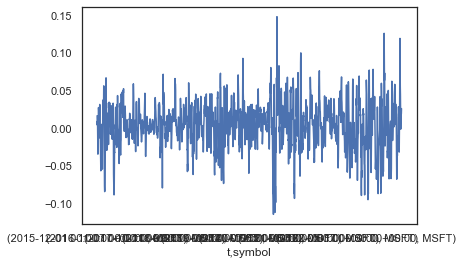

In [297]:
df_msft['pc12'].plot()

<AxesSubplot:xlabel='t,symbol'>

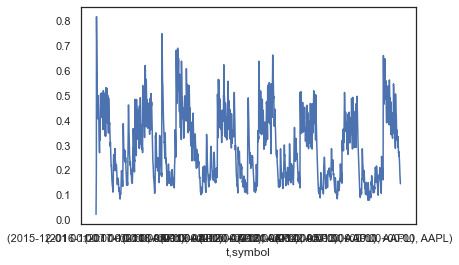

In [298]:
df_aapl['rlmS'].ewm(span=10).std().plot()

In [299]:
import seaborn as sns
def plot_corrmatrix(df):
    corr_matrix = df.corr()

    # Set up a Seaborn theme
    sns.set_theme(style="white")

    # Create a correlation matrix plot
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask to display only the lower triangle
    cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Generate a custom diverging colormap
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize": 10})
    plt.title("Correlation Matrix")
    plt.show()


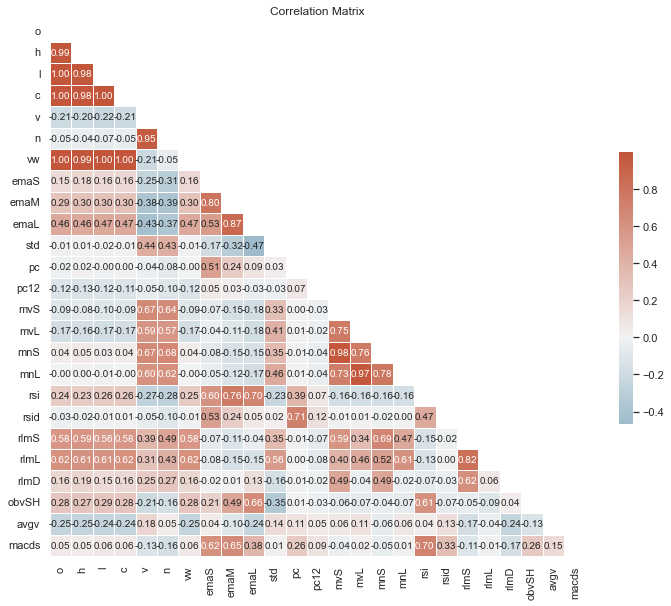

In [300]:
plot_corrmatrix(df_aapl)

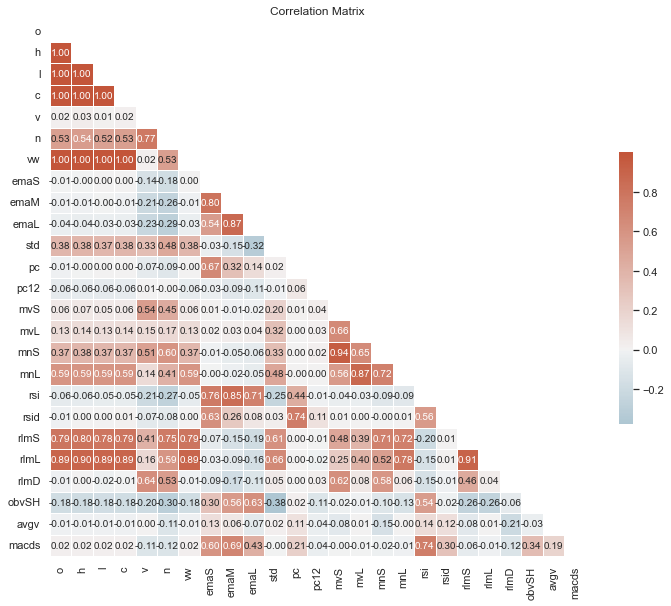

In [301]:
plot_corrmatrix(df_msft)

In [302]:
for k, df in stocks_data.items():
    stocks_data[k] = transform_dataset(df.copy(), transformations)

/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by ze

In [303]:
combined_df = pd.concat(stocks_data.values(), keys=stocks_data.keys()).reset_index()

In [304]:
combined_df.to_csv('bars_final_daily.csv')
combined_df.head()

,level_0,t,symbol,o,h,l,c,v,n,vw,...,mnS,mnL,rsi,rsid,rlmS,rlmL,rlmD,obvSH,avgv,macds
0,AAPL,2015-12-01 00:00:00+00:00,AAPL,118.88,119.00,116.86,117.23,34751854,186962,118.028408,...,12.138661,12.138661,NaN,NaN,0.760806,0.760806,0.000000,NaN,NaN,NaN
1,AAPL,2015-12-02 00:00:00+00:00,AAPL,117.28,118.11,116.08,116.40,33226679,180578,117.159981,...,12.117815,12.121000,0.000000,0.000000,0.729144,0.733981,-0.004837,NaN,-0.695322,-0.628539
2,AAPL,2015-12-03 00:00:00+00:00,AAPL,116.42,117.30,114.22,115.39,41551689,245283,115.950119,...,12.256298,12.220620,0.000000,0.000000,0.916621,0.868665,0.047956,-0.129636,-1.118357,-0.939042
3,AAPL,2015-12-04 00:00:00+00:00,AAPL,115.38,119.25,115.01,119.05,56682039,307695,117.409714,...,12.414379,12.329941,70.947343,37.340707,1.135920,1.019917,0.116003,0.090817,-0.437899,1.203516
4,AAPL,2015-12-05 00:00:00+00:00,AAPL,119.05,119.07,119.04,119.05,5236,23,119.053669,...,8.852343,10.366451,70.947343,21.829952,-0.646263,0.053280,-0.699544,0.194167,1.527276,1.191664
